# Imports

In [273]:
import sys, os

from math import log10
from numpy import array, pi

import pandas as pd
import numpy as np
from numpy import concatenate
from bisect import bisect_left
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from hist import Hist
import hist

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import zero_one_loss, roc_curve, roc_auc_score, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from sklearn.base import clone

# algorithms:
from sklearn.tree import export_graphviz, DecisionTreeClassifier, DecisionTreeRegressor #, plot_tree, export_text # Available in later versions
import graphviz

# Import data

In [274]:
import pandas as pd
import glob
import os

#if Helen 
#path = r"C:\Users\hpetr\Documents\University\Year 3\Bsc Project\Data"
#if Trinity
path = r"/Users/trinitystenhouse/Documents/University_MSci/2022-3/Project/Bsc-Project"

all_files = ["S2_only_AND_S1S2_Tritium.csv", "gate_data.csv", "gas_data.csv", "cathode_data.csv"]

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df.keys()


Index(['target', 'type', 'runID', 'evtID', 'S2_area', 'S2_btm_area',
       'S2_top_area', 'S2_TBA', 'S2_corrected_area', 'S2_XY_corrected_area',
       'S2_width_ns', 'S2_peakAmp', 'S2_AFT_5', 'S2_AFT_10', 'S2_AFT_25',
       'S2_AFT_50', 'S2_AFT_75', 'S2_AFT_90', 'S2_AFT_95', 'S2_rmsWidth_ns',
       'S2_fwhm_ns', 'S2_x_cm', 'S2_y_cm', 'S2_xy_chiSq', 'S2_n_saturated',
       'has_good_S1', 'drift_time', 'S1_area', 'S1_corrected_area',
       'evt_total_area', 'evt_bad_area', 'evt_bad_e_area', 'evt_bad_ph_area',
       'evt_bad_oth_area'],
      dtype='object')

# Setup plotting

In [275]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'family' : 'normal','weight' : 'normal','size'   : 22}
plt.rc('font', **font)

# Parameters

In [276]:
ana_thresh_e = 10
electron_size = 58.2

# Get data

In [277]:

# Add differences in AFT values
df['10_5']=df['S2_AFT_10']-df['S2_AFT_5']
df['25_10']=df['S2_AFT_25']-df['S2_AFT_10']
df['50_25']=df['S2_AFT_50']-df['S2_AFT_25']
df['75_50']=df['S2_AFT_75']-df['S2_AFT_50']
df['90_75']=df['S2_AFT_90']-df['S2_AFT_75']
df['95_90']=df['S2_AFT_95']-df['S2_AFT_90']

#df['half_width']=df.aft_t1_samples.astype('float64')-df.aft_t05_samples.astype('float64')
df.head()

,target,type,runID,evtID,S2_area,S2_btm_area,S2_top_area,S2_TBA,S2_corrected_area,S2_XY_corrected_area,...,evt_bad_area,evt_bad_e_area,evt_bad_ph_area,evt_bad_oth_area,10_5,25_10,50_25,75_50,90_75,95_90
0,1,Tritium,8136,66354,85.0,280.989014,579.317871,0.346770,970.152954,0.026862,...,184.130497,973.110676,71.456406,0.000000,1130.0,1160.0,1080.0,960.0,1030.0,390.0
1,1,Tritium,8155,20311,66.0,193.838470,589.805054,0.505289,828.374695,0.028991,...,275.584460,1008.871109,50.091458,0.569708,190.0,270.0,330.0,340.0,330.0,210.0
2,1,Tritium,8155,21688,82.0,340.851562,937.643555,0.466793,1292.567139,0.043853,...,198.399451,1389.213100,87.546946,0.000000,250.0,420.0,430.0,470.0,450.0,240.0
3,1,Tritium,8155,22490,76.0,764.374817,1699.066040,0.379425,-999.000000,0.087167,...,978.259415,3379.421276,61.650883,0.000000,160.0,420.0,670.0,630.0,560.0,310.0
4,1,Tritium,8170,55132,101.0,364.589966,1136.779419,0.514323,1552.668213,0.054341,...,263.321344,1675.346012,89.577138,0.000000,170.0,360.0,360.0,440.0,400.0,220.0


# Re-weight data

In [278]:
electron_axis = hist.axis.Regular(50,0.5,50.5,name="electrons",
                           label="Extracted electrons",flow=False)

In [279]:
df['ext_elec'] = (df["S2_top_area"] + df["S2_btm_area"]) /electron_size
df['ext_elec']

0        14.781905
1        13.464665
2        21.967270
3        42.327162
4        25.796725
           ...    
16255    42.031962
16256    45.842613
16257    93.578204
16258    54.994477
16259    98.738181
Name: ext_elec, Length: 16260, dtype: float64

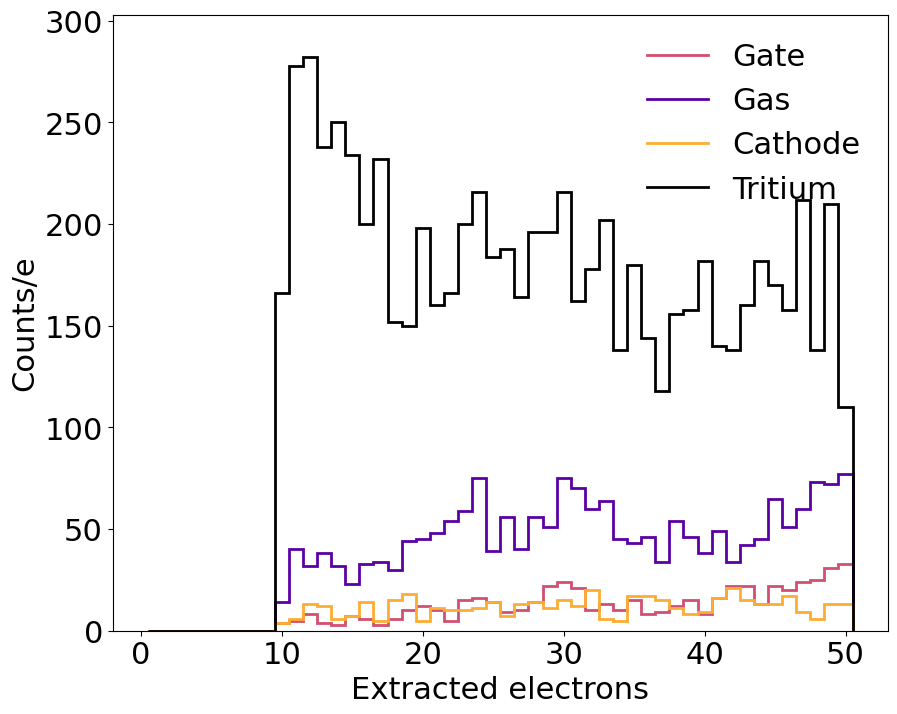

In [280]:
gate_hist = Hist(electron_axis)
gate_cut = df.type == "gate"
gate_hist.fill(df.ext_elec[gate_cut])

gas_hist = Hist(electron_axis)
gas_cut = df.type == "gas"
gas_hist.fill(df.ext_elec[gas_cut])

cath_hist = Hist(electron_axis)
cath_cut = df.type == "cath"
cath_hist.fill(df.ext_elec[cath_cut])

trit_hist = Hist(electron_axis)
trit_cut = df.type == "Tritium"
trit_hist.fill(df.ext_elec[trit_cut])

fig, ax = plt.subplots(figsize=(10, 8))
gate_hist.plot(color='#d24f71',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
gas_hist.plot(color='#5a01a4',ls='-',lw=2,yerr=False,label='Gas',ax=ax)
cath_hist.plot(color='#fdad32',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
plt.ylim(0, 303)
ax.set(xlabel='Extracted electrons',ylabel='Counts/e')
ax.legend(loc='upper right',frameon=False)

plt.savefig('Total_unweighted_hist.png')
plt.show()

In [281]:
weight_list = []

for ii in range(0, df.shape[0]):
    if df.type[ii] == 'gate':
        index = np.searchsorted(gate_hist.to_numpy()[1],df.ext_elec[ii]) - 1
        bin_counts = gate_hist.to_numpy()[1][index]
    elif df.type[ii] == 'gas':
        index = np.searchsorted(gas_hist.to_numpy()[1],df.ext_elec[ii]) - 1
        bin_counts = gas_hist.to_numpy()[1][index]
    elif df.type[ii] == 'cath':
        index = np.searchsorted(cath_hist.to_numpy()[1],df.ext_elec[ii]) - 1
        bin_counts = cath_hist.to_numpy()[1][index]
    elif df.type[ii] == 'Tritium':
        index = np.searchsorted(trit_hist.to_numpy()[1],df.ext_elec[ii]) - 1
        bin_counts = trit_hist.to_numpy()[1][index]     
    weight_list.append(1/bin_counts)
        
df['weights'] = weight_list

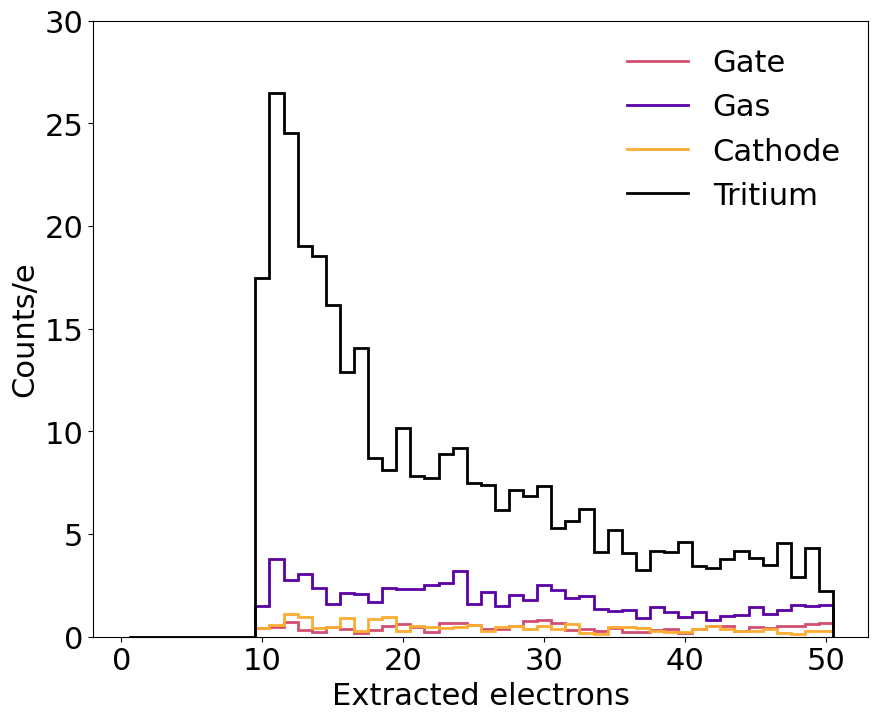

In [282]:
norm_gate_hist = Hist(electron_axis)
gate_cut = df.type == "gate"
norm_gate_hist.fill(df.ext_elec[gate_cut],weight = df.weights[gate_cut])

norm_gas_hist = Hist(electron_axis)
gas_cut = df.type == "gas"
norm_gas_hist.fill(df.ext_elec[gas_cut],weight = df.weights[gas_cut])

norm_cath_hist = Hist(electron_axis)
cath_cut = df.type == "cath"
norm_cath_hist.fill(df.ext_elec[cath_cut],weight = df.weights[cath_cut])

norm_trit_hist = Hist(electron_axis)
trit_cut = df.type == "Tritium"
norm_trit_hist.fill(df.ext_elec[trit_cut],weight = df.weights[trit_cut])

fig, ax = plt.subplots(figsize=(10, 8))
norm_gate_hist.plot(color='#d24f71',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
norm_gas_hist.plot(color='#5a01a4',ls='-',lw=2,yerr=False,label='Gas',ax=ax)
norm_cath_hist.plot(color='#fdad32',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
norm_trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)

ax.set(xlabel='Extracted electrons',ylabel='Counts/e',ylim=[0,30])
ax.legend(loc='upper right',frameon=False)
plt.savefig('Total_weighted_hist.png')
plt.show()


# Machine learning

### Prepare data for machine learning

In [283]:
df_ML = df[df.ext_elec > ana_thresh_e]#.loc[:,features]

df_ML.keys()

Index(['target', 'type', 'runID', 'evtID', 'S2_area', 'S2_btm_area',
       'S2_top_area', 'S2_TBA', 'S2_corrected_area', 'S2_XY_corrected_area',
       'S2_width_ns', 'S2_peakAmp', 'S2_AFT_5', 'S2_AFT_10', 'S2_AFT_25',
       'S2_AFT_50', 'S2_AFT_75', 'S2_AFT_90', 'S2_AFT_95', 'S2_rmsWidth_ns',
       'S2_fwhm_ns', 'S2_x_cm', 'S2_y_cm', 'S2_xy_chiSq', 'S2_n_saturated',
       'has_good_S1', 'drift_time', 'S1_area', 'S1_corrected_area',
       'evt_total_area', 'evt_bad_area', 'evt_bad_e_area', 'evt_bad_ph_area',
       'evt_bad_oth_area', '10_5', '25_10', '50_25', '75_50', '90_75', '95_90',
       'ext_elec', 'weights'],
      dtype='object')

In [286]:
def plot_singular(df_init):
    features = ['S2_peakAmp','10_5','25_10','50_25', \
                '75_50','90_75','95_90', 'ext_elec']

    X = df_init[features]
    Y = df_init['target']
    T = df_init['type']
    W = df_init['weights']
    A = df_init['S2_top_area'] + df_init['S2_btm_area']
    R = ((df_init['S2_x_cm'])**2 + (df_init['S2_y_cm'])**2)**0.5
    X_raw = df_init['S2_x_cm']
    Y_raw = df_init['S2_y_cm']
    #L = df_ML['luxstamp']
    X_train_unscaled, X_test_unscaled, \
    Y_train, Y_test, \
    A_train, A_test, \
    W_train, W_test, \
    T_train, T_test, \
    R_train, R_test, \
    X_raw_train, X_raw_test, \
    Y_raw_train, Y_raw_test = train_test_split(X, Y, A, W, T, R, X_raw, Y_raw, random_state=0)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train_unscaled.astype('float64'))
    X_test = scaler.transform(X_test_unscaled.astype('float64'))
    
    DTC = DecisionTreeClassifier(max_depth=2,min_samples_split=2)
    ABC = AdaBoostClassifier(base_estimator=DTC,n_estimators=100, algorithm = 'SAMME')
    model = ABC.fit(X_train, Y_train.values.ravel()
                    ,sample_weight=W_train.values.ravel().astype('float64'))

    Y_score = model.decision_function(X_test)

    model.score(X_train, Y_train, sample_weight=W_train.astype('float64')), \
    model.score(X_test, Y_test, sample_weight=W_test.astype('float64')) 
    FPR,TPR,TH = roc_curve(Y_test,Y_score,sample_weight = W_test, pos_label = 1)
    ABDT_auc = roc_auc_score(Y_test,Y_score)
    
    return [FPR,TPR,ABDT_auc]

In [288]:
#Aim is to plot ROC curves for all the different bins. 

def dataframe_gen(df_init):
    df_10to15 = df_init.copy(deep=True)
    df_10to15 = df_10to15[(df_10to15.ext_elec < 15.5)]

    df_15to20 = df_init.copy(deep=True)
    df_15to20 = df_15to20[(df_15to20.ext_elec > 14.5) & (df_15to20.ext_elec < 20.5)]

    df_20to25 = df_init.copy(deep=True)
    df_20to25 = df_20to25[(df_20to25.ext_elec > 19.5) & (df_20to25.ext_elec < 25.5)]

    df_25to30 = df_init.copy(deep=True)
    df_25to30 = df_25to30[(df_25to30.ext_elec > 24.5) & (df_25to30.ext_elec < 30.5)]

    df_30to35 = df_init.copy(deep=True)
    df_30to35 = df_30to35[(df_30to35.ext_elec > 14.5) & (df_30to35.ext_elec < 30.5)]

    df_35to40 = df_init.copy(deep=True)
    df_35to40 = df_35to40[(df_35to40.ext_elec > 34.5) & (df_35to40.ext_elec < 40.5)]

    df_40to45 = df_init.copy(deep=True)
    df_40to45 = df_40to45[(df_40to45.ext_elec > 39.5) & (df_40to45.ext_elec < 45.5)]

    df_45to50 = df_init.copy(deep=True)
    df_45to50 = df_45to50[(df_45to50.ext_elec > 44.5) & (df_45to50.ext_elec < 50.5)]
    
    data = [[df_10to15, [10,15], '#220690'], [df_15to20, [15,20], '#9f7ecd'], [df_20to25, [20,25], '#00ffff'], [df_25to30, [25,30],'#f5ec27'], [df_30to35, [30,35], '#c8457a'], [df_35to40,[35,40],'#e56a5d' ], [df_40to45, [40,45], "#6029ad" ], [df_45to50, [45,50], "#fdad32"]]

    return data

In [289]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'family' : 'normal','weight' : 'normal','size'   : 15}
plt.rc('font', **font)

In [312]:
#training on each background separately

gas_cut = df.type == "gas"
gate_cut = df.type == "gate"
cath_cut = df.type == "cath"
trit_cut = df.type == "Tritium"

df_cath = pd.concat([df[cath_cut], df[trit_cut]], axis=0, ignore_index=True)
FPR_cath,TPR_cath,ABDT_auc_cath = plot_singular(df_cath)
df_gategas = pd.concat([df[gas_cut], df[gate_cut], df[trit_cut]], axis=0, ignore_index=True)
FPR_gategas,TPR_gategas,ABDT_auc_gategas = plot_singular(df_gategas)
df_gas = pd.concat([df[gas_cut], df[trit_cut]], axis=0, ignore_index=True)
FPR_gas,TPR_gas,ABDT_auc_gas = plot_singular(df_gas)
df_gate = pd.concat([df[gate_cut], df[trit_cut]], axis=0, ignore_index=True)
FPR_gate,TPR_gate,ABDT_auc_gate = plot_singular(df_gate)

/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [313]:
def plot_ROC_ABDT(frame, limits, color):
    features = ['S2_peakAmp','10_5','25_10','50_25', \
            '75_50','90_75','95_90', 'ext_elec']

    X = frame[features]
    Y = frame['target']
    T = frame['type']
    W = frame['weights']
    A = frame['S2_top_area'] + frame['S2_btm_area']
    R = ((frame['S2_x_cm'])**2 + (frame['S2_y_cm'])**2)**0.5
    X_raw = frame['S2_x_cm']
    Y_raw = frame['S2_y_cm']
    #L = df_ML['luxstamp']
    X_train_unscaled, X_test_unscaled, \
    Y_train, Y_test, \
    A_train, A_test, \
    W_train, W_test, \
    T_train, T_test, \
    R_train, R_test, \
    X_raw_train, X_raw_test, \
    Y_raw_train, Y_raw_test = train_test_split(X, Y, A, W, T, R, X_raw, Y_raw, random_state=0)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train_unscaled.astype('float64'))
    X_test = scaler.transform(X_test_unscaled.astype('float64'))
    
    DTC = DecisionTreeClassifier(max_depth=2,min_samples_split=2)
    ABC = AdaBoostClassifier(base_estimator=DTC,n_estimators=100, algorithm = 'SAMME')
    model = ABC.fit(X_train, Y_train.values.ravel()
                    ,sample_weight=W_train.values.ravel().astype('float64'))

    Y_score = model.decision_function(X_test)

    model.score(X_train, Y_train, sample_weight=W_train.astype('float64')), \
    model.score(X_test, Y_test, sample_weight=W_test.astype('float64')) 
    
    FPR,TPR,TH = roc_curve(Y_test,Y_score,sample_weight = W_test, pos_label = 1)
    zero = limits[0]
    one = limits[1]
    ABDT_auc = roc_auc_score(Y_test,Y_score)
    plt.plot(FPR,TPR, label= (str(zero)+'<n$_{e}$<'+str(one)+', auc='+str('{0:.5g}'.format(ABDT_auc))), color = color)


/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 

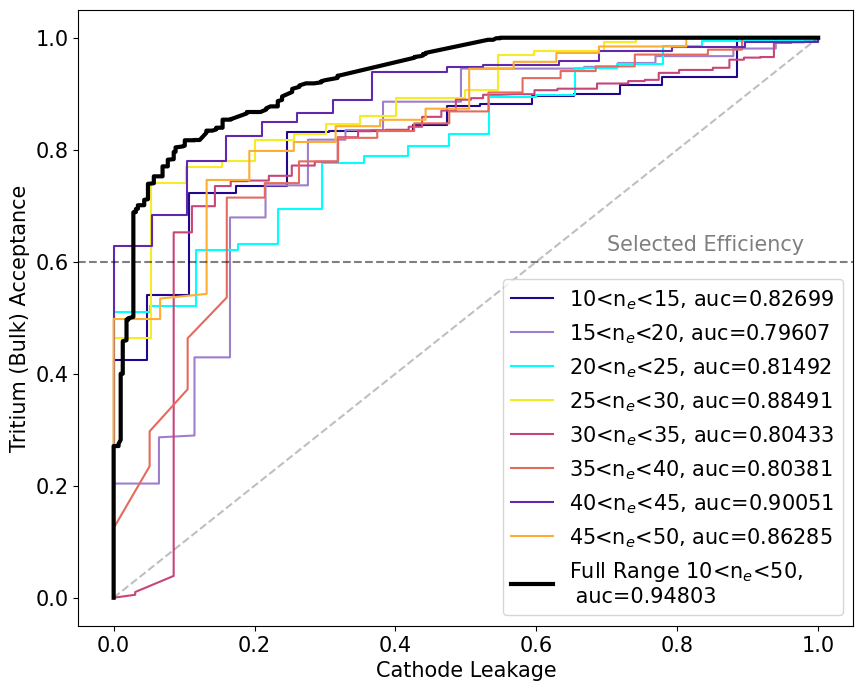

In [314]:
data = dataframe_gen(df_cath)
for d in data:    
    plot_ROC_ABDT(d[0], d[1], d[2])
    
plt.axhline(y = 0.6, ls='--', color = 'black', alpha = 0.5)
plt.plot([0, 1], ls="--", color = 'black', alpha = 0.25)
plt.plot(FPR_cath,TPR_cath, label= ('Full Range 10<n$_{e}$<50, \n auc='+str('{0:.5g}'.format(ABDT_auc_cath))), color = 'black', linewidth=3)
plt.text(0.7,0.62,'Selected Efficiency', alpha = 0.5)
plt.legend(loc=4)
plt.ylabel('Tritium (Bulk) Acceptance')
plt.xlabel('Cathode Leakage')
plt.savefig('ROC_ABDT_cath.png')
plt.show()


/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 

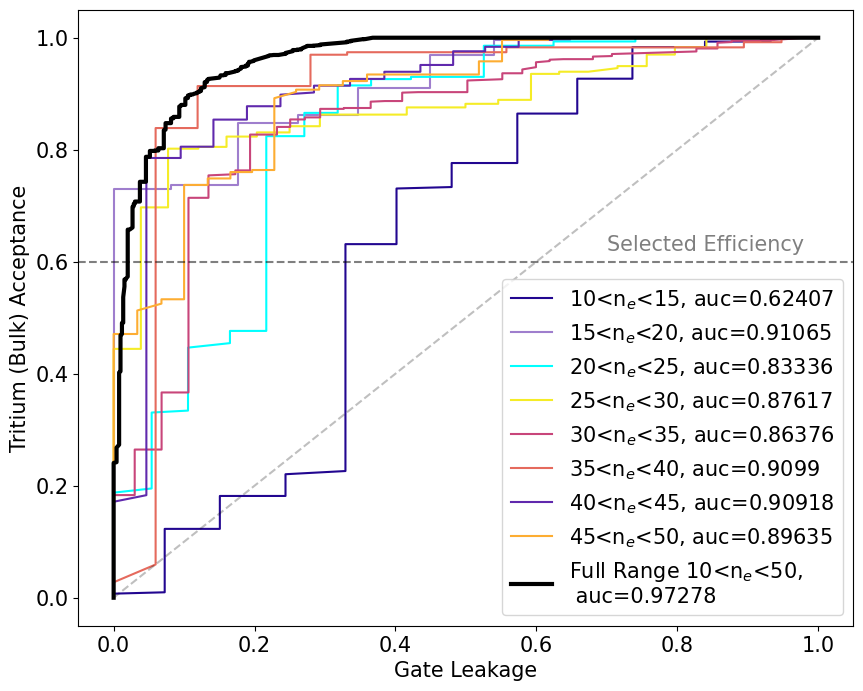

In [315]:
data = dataframe_gen(df_gate)
for d in data:    
    plot_ROC_ABDT(d[0], d[1], d[2])
    
plt.axhline(y = 0.6, ls='--', color = 'black', alpha = 0.5)
plt.plot([0, 1], ls="--", color = 'black', alpha = 0.25)
plt.plot(FPR_gate,TPR_gate, label= ('Full Range 10<n$_{e}$<50, \n auc='+str('{0:.5g}'.format(ABDT_auc_gate))), color = 'black', linewidth=3)
plt.text(0.7,0.62,'Selected Efficiency', alpha = 0.5)
plt.legend(loc=4)
plt.ylabel('Tritium (Bulk) Acceptance')
plt.xlabel('Gate Leakage')
plt.savefig('ROC_ABDT_gate.png')
plt.show()

/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 

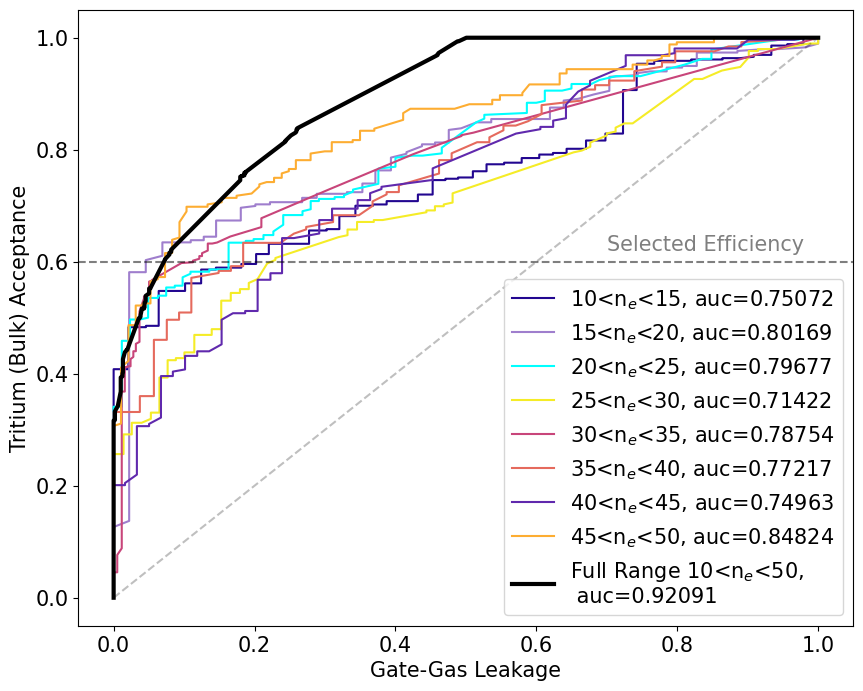

In [316]:
data = dataframe_gen(df_gas)
for d in data:    
    plot_ROC_ABDT(d[0], d[1], d[2])
    
plt.axhline(y = 0.6, ls='--', color = 'black', alpha = 0.5)
plt.plot([0, 1], ls="--", color = 'black', alpha = 0.25)
plt.plot(FPR_gas,TPR_gas, label= ('Full Range 10<n$_{e}$<50, \n auc='+str('{0:.5g}'.format(ABDT_auc_gas))), color = 'black', linewidth=3)
plt.text(0.7,0.62,'Selected Efficiency', alpha = 0.5)
plt.legend(loc=4)
plt.ylabel('Tritium (Bulk) Acceptance')
plt.xlabel('Gate-Gas Leakage')
plt.savefig('ROC_ABDT_gas.png')
plt.show()

In [245]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'family' : 'normal','weight' : 'normal','size'   : 15}
plt.rc('font', **font)

/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 

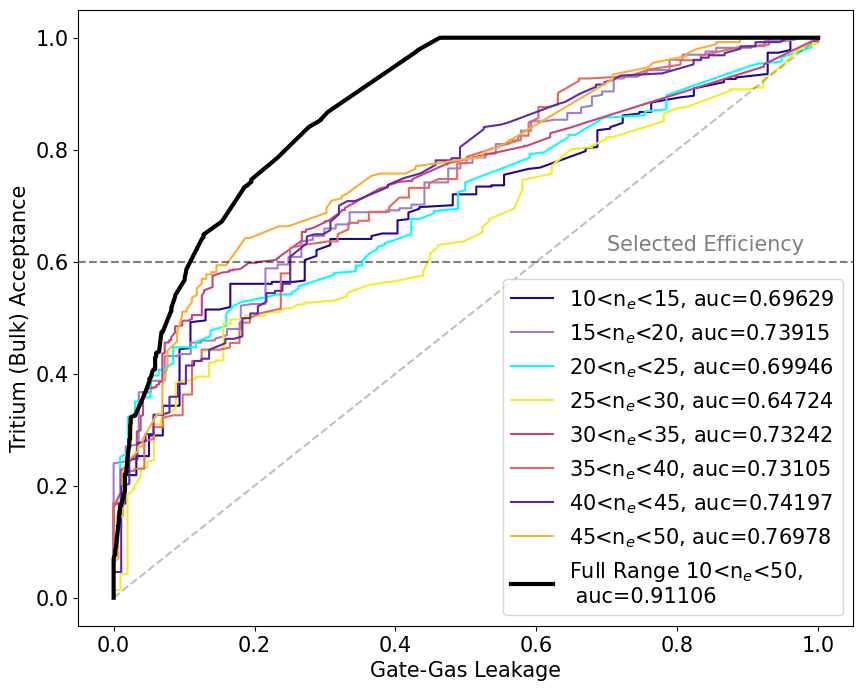

In [317]:
data = dataframe_gen(df_gategas)
for d in data:    
    plot_ROC_ABDT(d[0], d[1], d[2])
    
plt.axhline(y = 0.6, ls='--', color = 'black', alpha = 0.5)
plt.plot([0, 1], ls="--", color = 'black', alpha = 0.25)
plt.plot(FPR_gategas,TPR_gategas, label= ('Full Range 10<n$_{e}$<50, \n auc='+str('{0:.5g}'.format(ABDT_auc_gategas))), color = 'black', linewidth=3)
plt.text(0.7,0.62,'Selected Efficiency', alpha = 0.5)
plt.legend(loc=4)
plt.ylabel('Tritium (Bulk) Acceptance')
plt.xlabel('Gate-Gas Leakage')
plt.savefig('ROC_ABDT_gategas.png')
plt.show()

## Adaptively boosted decision tree

In [124]:
DTC = DecisionTreeClassifier(max_depth=2,min_samples_split=2)
ABC = AdaBoostClassifier(base_estimator=DTC,n_estimators=100, algorithm = 'SAMME')
model = ABC.fit(X_train, Y_train.values.ravel()
                ,sample_weight=W_train.values.ravel().astype('float64'))

Y_score = model.decision_function(X_test)

model.score(X_train, Y_train, sample_weight=W_train.astype('float64')), \
model.score(X_test, Y_test, sample_weight=W_test.astype('float64')) 

/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


(0.7551685239655549, 0.7439894740082316)

# Understanding machine learning

random forest

knn

svm - if separable

gaussian mixture model

hidden markov model 

CNN- feed forward NN 

# Results

In [95]:
FPR,TPR,TH = roc_curve(Y_test,Y_score,sample_weight = W_test, pos_label = 1)


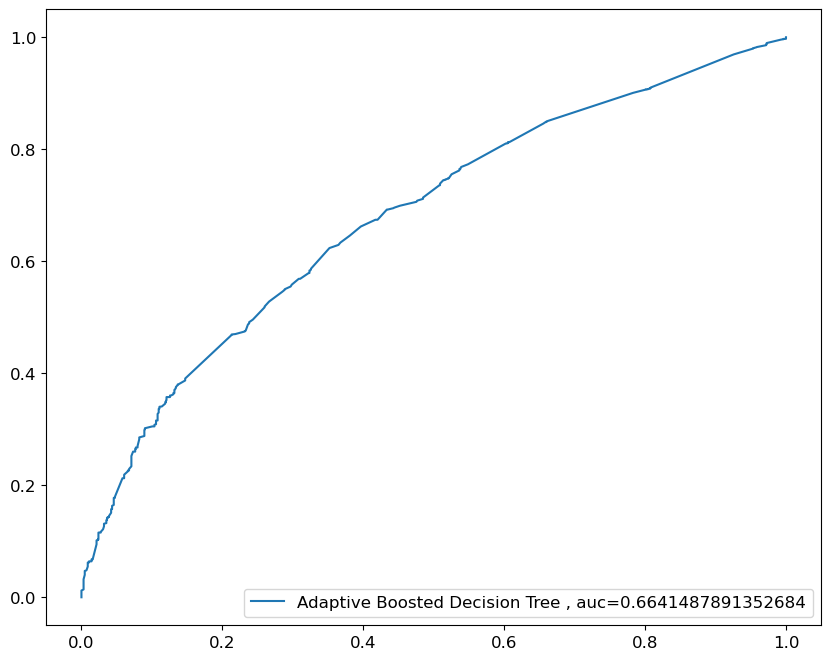

In [96]:
ABDT_auc = roc_auc_score(Y_test,Y_score)
plt.plot(FPR,TPR,label="Adaptive Boosted Decision Tree , auc="+str(ABDT_auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#Threshold cut 
x = (tritium_like_arr['S2_top_area'] + tritium_like_arr['S2_btm_area'])
conditions = (x /58.2) < 100
x = np.log10(x /58.2)
thresholdline = plt.Line2D((1, 1), (0, 4000), color = '#5a01a4', ls ='--', label = 'Threshold Cut')
fig, ax = plt.subplots()
h = ax.hist(x[conditions], bins=100, fill = False, histtype='step', linewidth=2, facecolor='c', color = 'black', log = True)

plt.xlim(0,2)
plt.ylim(0,400)
ax.add_line(thresholdline)
plt.xlabel('Detected Electrons')
plt.ylabel('Events / Electron')
ax.legend(loc='upper right',frameon=False)
plt.title('Threshold Plot')
plt.show()

plt.savefig('S1S2_threshold_cut.png')

## BDT

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


12195


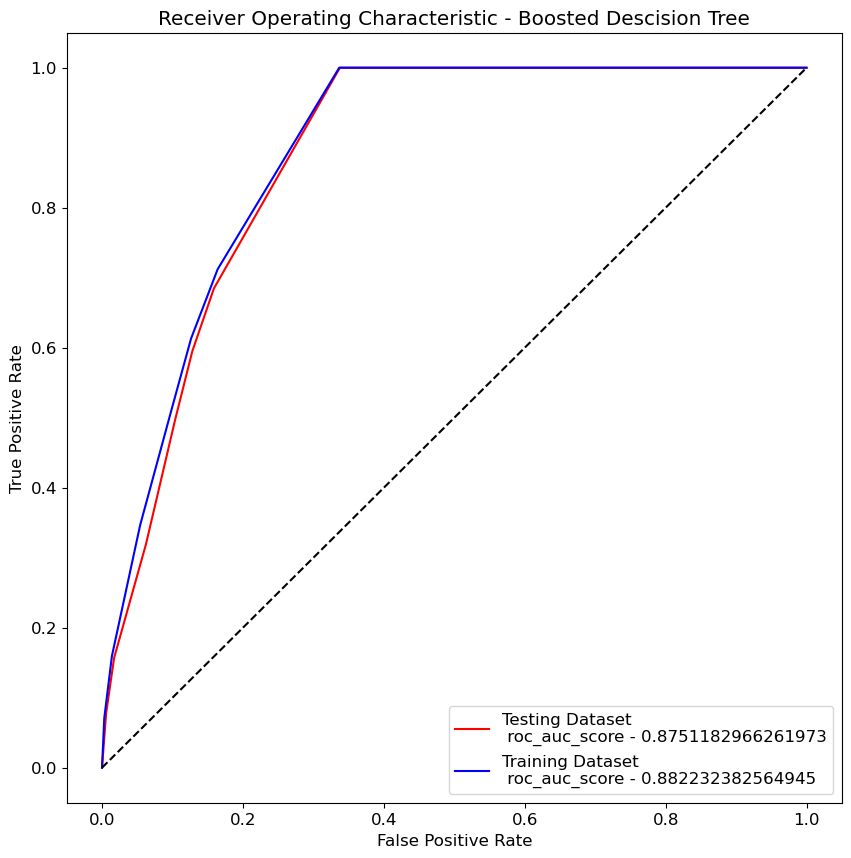

In [23]:
seed = 42
test_size = 0.2

#Creating the three different data sets
features = ['S2_peakAmp','10_5','25_10','50_25', \
            '75_50','90_75','95_90', 'ext_elec']

X = df_ML[features]
Y = df_ML['target']
T = df_ML['type']
W = df_ML['weights']
A = df_ML['S2_top_area'] + df_ML['S2_btm_area']
R = ((df_ML['S2_x_cm'])**2 + (df_ML['S2_y_cm'])**2)**0.5
X_raw = df_ML['S2_x_cm']
Y_raw = df_ML['S2_y_cm']
#L = df_ML['luxstamp']
X_train_unscaled, X_test_unscaled, \
Y_train, Y_test, \
A_train, A_test, \
W_train, W_test, \
T_train, T_test, \
R_train, R_test, \
X_raw_train, X_raw_test, \
Y_raw_train, Y_raw_test = train_test_split(X, Y, A, W, T, R, X_raw, Y_raw, random_state=0)

reg = DecisionTreeRegressor(max_depth = 4, random_state = seed)
print(len(Y_train))
reg.fit(X_train, Y_train)
#model = train_model(X_train,y_train,X_test,y_test)

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Boosted Descision Tree')
Y_score_test = reg.predict(X_test)
Y_score_train = reg.predict(X_train)
false_positive_rate_test, true_positive_rate_test, threshold_test = roc_curve(Y_test, Y_score_test, pos_label=1)
false_positive_rate_train, true_positive_rate_train, threshold_train = roc_curve(Y_train, Y_score_train, pos_label=1)
plt.plot(false_positive_rate_test, true_positive_rate_test, label = "Testing Dataset \n roc_auc_score - {}".format(roc_auc_score(Y_test, Y_score_test)), color = 'r')
plt.plot(false_positive_rate_train, true_positive_rate_train, label = "Training Dataset \n roc_auc_score - {}".format(roc_auc_score(Y_train, Y_score_train)), color = 'b')
plt.plot([0, 1], ls="--", color = 'black')
#plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
reg.fit(X_train, Y_train)
#cm = confusion_matrix(Y_score_test, Y_score_train)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#disp.plot()
ax.legend(loc='upper left',frameon=False)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
#plt.savefig("Overfitting_Graphs/Overfitting_combo_graph.jpg", bbox_inches="tight", pad_inches=0, format="jpg", dpi=600)
plt.show()

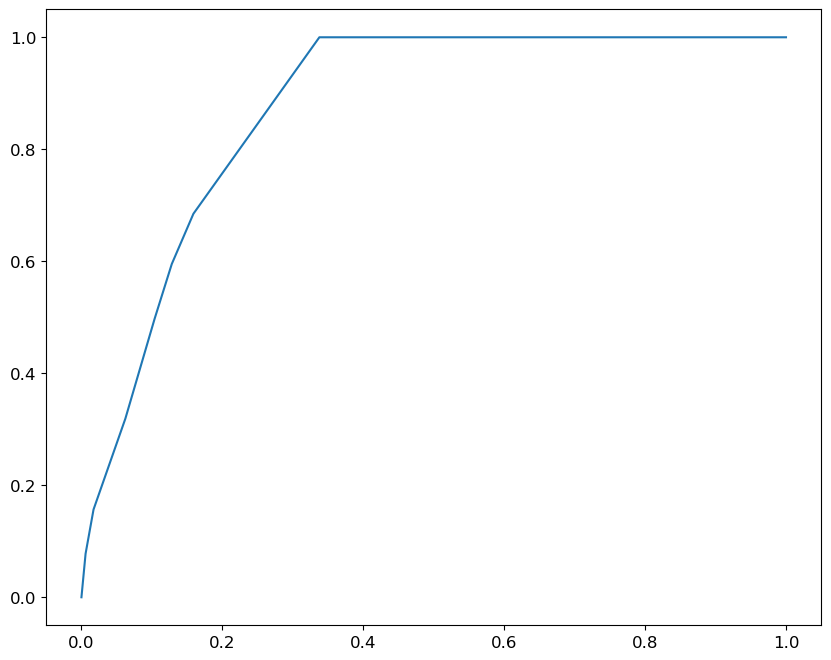

In [24]:
plt.plot(false_positive_rate_test, true_positive_rate_test,label = "Testing Dataset \n roc_auc_score - {}".format(roc_auc_score(Y_test, Y_score_test)))

## Attempted CNN

In [25]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np

2023-03-11 14:05:18.813108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [137]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
features = ['S2_peakAmp','10_5','25_10','50_25', \
            '75_50','90_75','95_90', 'ext_elec']

X = df_ML[features]
Y = df_ML['target']
T = df_ML['type']
W = df_ML['weights']
A = df_ML['S2_top_area'] + df_ML['S2_btm_area']
R = ((df_ML['S2_x_cm'])**2 + (df_ML['S2_y_cm'])**2)**0.5
X_raw = df_ML['S2_x_cm']
Y_raw = df_ML['S2_y_cm']
#L = df_ML['luxstamp']
X_train_unscaled, X_test_unscaled, \
Y_train, Y_test, \
A_train, A_test, \
W_train, W_test, \
T_train, T_test, \
R_train, R_test, \
X_raw_train, X_raw_test, \
Y_raw_train, Y_raw_test = train_test_split(X, Y, A, W, T, R, X_raw, Y_raw, random_state=0)

#x_train = x_train.reshape(60000,28,28,1)
#x_test = x_test.reshape(10000,28,28,1)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('y_train shape:', Y_train.shape)

X_train shape: (8778, 8)
8778 train samples
2927 test samples
y_train shape: (8778, 10)


In [138]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [140]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12


ValueError: in user code:

    File "/Users/trinitystenhouse/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/Users/trinitystenhouse/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/trinitystenhouse/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/Users/trinitystenhouse/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/Users/trinitystenhouse/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/trinitystenhouse/opt/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 28, 28, 1), found shape=(None, 8)
